# 0. Setup

In [56]:
import os

labelbox_dir = "./data/labelbox"
labelbox_landcover_dir = f'{labelbox_dir}/landcover'
labelbox_landcover_rgb_dir = f'{labelbox_landcover_dir}/rgb'
labelbox_landcover_labels_dir = f'{labelbox_landcover_dir}/labels'
labelbox_landcover_source_dir = f'{labelbox_landcover_dir}/source'
labelbox_landcover_temp_dir = f'{labelbox_landcover_dir}/temp'

os.makedirs(labelbox_landcover_labels_dir, exist_ok=True)
os.makedirs(labelbox_landcover_rgb_dir, exist_ok=True)
os.makedirs(labelbox_landcover_source_dir, exist_ok=True)
os.makedirs(labelbox_landcover_temp_dir, exist_ok=True)

landcover_state_path = "./data/labelbox/landcover/uploadState"
cloud_detection_model_path = os.path.join(os.getcwd(), 'cloud_detection_model_resnet18_dice_20230324.pth')


In [3]:

try:
    from common.sagemaker_env import LABELBOX_API_KEY
except: 
    LABELBOX_API_KEY = os.environ['LABELBOX_API_KEY']
    
LANDCOVER_PROJECT_ID = "clcrkcvn9281j07xybmww69pn"


# 1. Create chips and upload to Labelbox

In [45]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from patchify import patchify
import rasterio
import rasterio.transform

from common.constants import NODATA_BYTE, NODATA_FLOAT32, RES, S2_BANDS_TIFF_ORDER
import common.utilities.download as download
import common.utilities.imagery as imagery
import common.utilities.masking as masking

PATCH_SIZE = 512


def create_landcover_chips_from_bbox(bbox, start_date, end_date):
    
    collection_path = f'{labelbox_landcover_temp_dir}/collection.json'
    collection = download.get_collection(start_date, end_date, bbox, collection_path, max_cloud_cover=60, max_tile_count=1, min_tile_count=1)
    original_scenes = download.download_collection(collection, bbox, S2_BANDS_TIFF_ORDER, labelbox_landcover_temp_dir, RES)

    for scene in original_scenes:
        print(f'\tpatchifying... {scene}')
        
        meta = original_scenes[scene]['meta']
        stack_path = original_scenes[scene]["stack_original_tif_path"]
        with rasterio.open(stack_path) as src:
            if src.width < 512 or src.height < 512:
                print(f'\t\tskipping... {scene}')
                continue

        bbox_str = ''.join([str(round(coord, 2)) for coord in bbox]).replace('.', '').replace('-', 'n')
        
        with rasterio.open(stack_path) as stack_src:
            stack_data = stack_src.read(masked=True).transpose((1, 2, 0))
            transform = stack_src.transform

            source_patches = patchify(stack_data, (PATCH_SIZE, PATCH_SIZE, stack_data.shape[2]), step=PATCH_SIZE)
            
            for irow in range(source_patches.shape[0]):
                for icol in range(source_patches.shape[1]):
                    source_data = source_patches[irow, icol, 0, :, :, :]  
                    source_data = np.ma.array(source_data, mask=(source_data==NODATA_FLOAT32))
                      
                    # save basic normalized source data, then later if can do percentile normalization if things aren't working
                    source_data = source_data.transpose((2, 0, 1))
                    source_data, pct_masked = masking.apply_nn_cloud_mask('', meta, '', cloud_detection_model_path, bbox=bbox, stack_data=source_data)
                    
                    if pct_masked > 0.60:
                        print(f'\t\t{round(pct_masked*100, 2)}% masked; skipping r{irow} c{icol}')
                        continue
                                        
                    rgb_data = source_data[[2, 1, 0], :, :]
                    rgb_data = imagery.normalize_3d_array_percentiles(rgb_data, p_low=0.1, p_high=99.9)                    
                    rgb_data_norm = (rgb_data * 254).astype(np.uint8)
                    rgb_data_norm[rgb_data_norm > 254] = 254
        
                    rgb_path = f'{labelbox_landcover_rgb_dir}/{scene}_{bbox_str}_{irow}_{icol}.tif'
                    source_path = f'{labelbox_landcover_source_dir}/{scene}_{bbox_str}_{irow}_{icol}.tif'
                    
                    x_min, y_min = rasterio.transform.xy(transform, PATCH_SIZE*(irow+1), PATCH_SIZE*icol)
                    x_max, y_max = rasterio.transform.xy(transform, PATCH_SIZE*irow, PATCH_SIZE*(icol+1))             
                    chip_bbox = [x_min, y_min, x_max, y_max]          

                    source_data = source_data.transpose((1, 2, 0))
                    rgb_data_norm = rgb_data_norm.transpose((1, 2, 0))
                        
                    imagery.write_array_to_tif(source_data, source_path, chip_bbox, dtype=np.float32, nodata=NODATA_FLOAT32)
                    imagery.write_array_to_tif(rgb_data_norm, rgb_path, chip_bbox, dtype=np.uint8, nodata=NODATA_BYTE, is_cog=True)   
                    

In [46]:
import common.constants as constants
import common.aws.s3 as s3_utils


def save_landcover_rgb_chip_to_s3(rgb_path):
    file_name = rgb_path.split('/')[-1]    
    object_key = f'training/landcover/rgb/{file_name}'
    href = f'https://data.smartcarte.earth/{object_key}'
    s3_utils.put_item(rgb_path, constants.S3_DATA_BUCKET, object_key)
    return href


In [47]:
import datetime
from labelbox import Client, Dataset, DataRow
import glob
import os
import shelve


client = Client(api_key=LABELBOX_API_KEY)
project = client.get_project(LANDCOVER_PROJECT_ID)


def create_labelbox_landcover_dataset(prefix=""):
    
    today = datetime.datetime.today().strftime('%Y%m%d_%H%M')
    landcover_dataset_name = f"Landcover {prefix} {today}"

    print(f'processing {landcover_dataset_name}')
    
    landcover_dataset = client.get_datasets(where=(Dataset.name==landcover_dataset_name)).get_one()
    if landcover_dataset is not None:
        raise ValueError("landcover dataset already exists; wait a minute")        

    rgb_paths = glob.glob(f'{labelbox_landcover_rgb_dir}/*[0-9].tif')
    print(f'\t{len(rgb_paths)} total chips')
        
    with shelve.open(landcover_state_path) as upload_state:
        
        payload = []
        for rgb_path in rgb_paths:
            chip_id = rgb_path.split('/')[-1].replace('.tif', '')
            chip_state = upload_state.get(chip_id)
            
            if chip_state and chip_state.get('uploaded_to_labelbox', False):
                continue
            
            s3_href = save_landcover_rgb_chip_to_s3(rgb_path)
            
            payload.append({
                "chip_id": chip_id,
                "min_zoom": 12,
                "max_zoom": 15,
                "tile_layer_url": s3_href
            })

            upload_state[chip_id] = {
                'rgb_cog_href': s3_href,
                'uploaded_to_s3': True,
                'uploaded_to_labelbox': False
            }
 
        print(f'\t{len(payload)} chips to add to Labelbox')
        
        if len(payload) > 0:

            landcover_dataset = client.create_dataset(name=landcover_dataset_name)
            datarow_payload = [{DataRow.row_data: row} for row in payload]
            task = landcover_dataset.create_data_rows(datarow_payload)
            task.wait_till_done()

            for row in payload:
                chip_id = row["chip_id"]
                upload_state[chip_id] = {
                    'rgb_cog_href': s3_href,
                    'uploaded_to_s3': True,
                    'uploaded_to_labelbox': True
                }
            

In [48]:
import shutil


def create_new_chips(bbox, region_name, dates):
    for date in dates:
        start_date, end_date = date[0], date[1]
        create_landcover_chips_from_bbox(bbox, start_date, end_date)
        
    create_labelbox_landcover_dataset(prefix=region_name)
    
    
def clean_up():
    if os.path.exists(labelbox_landcover_temp_dir):
        shutil.rmtree(labelbox_landcover_temp_dir)
        os.makedirs(labelbox_landcover_temp_dir, exist_ok=True)



In [49]:
import datetime as dt

dates = [
    (dt.datetime(2019, 1, 1), dt.datetime(2019, 2, 1)),
    (dt.datetime(2020, 3, 1), dt.datetime(2020, 4, 1)),
    (dt.datetime(2021, 6, 1), dt.datetime(2021, 7, 1)),
    (dt.datetime(2022, 9, 1), dt.datetime(2022, 10, 1)),
]


## Virunga National Park (Volcano Sector) 🌋

In [51]:

bbox_volcano = [29.037475, -1.445046, 29.345781, -1.269466]
create_new_chips(bbox_volcano, "Virunga Volcano Sector", dates)
clean_up()

print('done')

done


## Virunga National Park (Ndwali) 🦛

In [37]:

bbox_ndwali = [29.265225, -0.728130, 29.480121, -0.584068]
create_new_chips(bbox_ndwali, "Virunga Ndwali", dates)
clean_up()

print('done')

./data/labelbox/landcover/temp/collection.json: {'QV': 1}
	downloading... S2B_35MQV_20190123_0_L2A
	patchifying... S2B_35MQV_20190123_0_L2A
./data/labelbox/landcover/temp/collection.json: {'QV': 1}
	downloading... S2A_35MQV_20200303_0_L2A
	patchifying... S2A_35MQV_20200303_0_L2A
./data/labelbox/landcover/temp/collection.json: {'QV': 1}
	downloading... S2B_35MQV_20210611_0_L2A
	patchifying... S2B_35MQV_20210611_0_L2A
./data/labelbox/landcover/temp/collection.json: {'QV': 1}
	downloading... S2A_35MQV_20220929_0_L2A
	patchifying... S2A_35MQV_20220929_0_L2A
processing Landcover Virunga Ndwali 20230326_2212
	94 total chips
	0 chips to add to Labelbox
done


## Virunga National Park (Gorilla Sector) 🦍

In [39]:

bbox_gorilla = [29.355053, -1.539090, 29.591672, -1.264626]
create_new_chips(bbox_gorilla, "Virunga Gorilla Sector", dates)
clean_up()

print('done')

./data/labelbox/landcover/temp/collection.json: {'QU': 1}
	downloading... S2B_35MQU_20190123_0_L2A
	patchifying... S2B_35MQU_20190123_0_L2A
		87.31% masked; skipping r2 c3
		68.92% masked; skipping r2 c4
		76.95% masked; skipping r3 c0
		98.55% masked; skipping r3 c1
		95.2% masked; skipping r3 c2
		96.77% masked; skipping r3 c3
		84.76% masked; skipping r3 c4
		94.43% masked; skipping r4 c0
		96.82% masked; skipping r4 c1
		99.94% masked; skipping r4 c2
		100.0% masked; skipping r4 c3
		81.67% masked; skipping r4 c4
./data/labelbox/landcover/temp/collection.json: {'QU': 1}
	downloading... S2A_35MQU_20200323_0_L2A
	patchifying... S2A_35MQU_20200323_0_L2A
		91.79% masked; skipping r2 c0
		79.25% masked; skipping r2 c4
		99.61% masked; skipping r4 c0
		63.23% masked; skipping r4 c4
./data/labelbox/landcover/temp/collection.json: {'QU': 1}
	downloading... S2B_35MQU_20210611_0_L2A
	patchifying... S2B_35MQU_20210611_0_L2A
		79.78% masked; skipping r3 c4
		84.21% masked; skipping r4 c4
./dat

## Virunga National Park (Ishango) 🐟

In [40]:

bbox_ishango = [29.516798, -0.163506, 29.693365, -0.026481]
create_new_chips(bbox_ishango, "Virunga Ishango", dates)
clean_up()

print('done')

./data/labelbox/landcover/temp/collection.json: {'QA': 1, 'QV': 1}
	downloading... S2B_35NQA_20190123_0_L2A
	downloading... S2B_35MQV_20190123_0_L2A
	patchifying... S2B_35NQA_20190123_0_L2A
	patchifying... S2B_35MQV_20190123_0_L2A
./data/labelbox/landcover/temp/collection.json: {'QA': 1, 'QV': 1}
	downloading... S2A_35NQA_20200323_0_L2A
	downloading... S2A_35MQV_20200303_0_L2A
	patchifying... S2A_35NQA_20200323_0_L2A
	patchifying... S2A_35MQV_20200303_0_L2A
./data/labelbox/landcover/temp/collection.json: {'QV': 1, 'QA': 1}
	downloading... S2B_35MQV_20210611_0_L2A
	downloading... S2B_35NQA_20210621_0_L2A
	patchifying... S2B_35MQV_20210611_0_L2A
	patchifying... S2B_35NQA_20210621_0_L2A
./data/labelbox/landcover/temp/collection.json: {'QV': 1, 'QA': 1}
	downloading... S2A_35MQV_20220929_0_L2A
	downloading... S2A_35NQA_20220929_0_L2A
	patchifying... S2A_35MQV_20220929_0_L2A
		79.09% masked; skipping r0 c0
	patchifying... S2A_35NQA_20220929_0_L2A
		79.3% masked; skipping r0 c0
processing La

## Okapi Wildlife Reserve 🌳

In [41]:

bbox_okapi = [28.524382, 1.376513, 28.716677, 1.515305]
create_new_chips(bbox_okapi, "Okapi", dates)
clean_up()

print('done')


./data/labelbox/landcover/temp/collection.json: {'PB': 1}
	downloading... S2A_35NPB_20190121_0_L2A
	patchifying... S2A_35NPB_20190121_0_L2A
./data/labelbox/landcover/temp/collection.json: {'PB': 1}
	downloading... S2B_35NPB_20200331_0_L2A
	patchifying... S2B_35NPB_20200331_0_L2A
./data/labelbox/landcover/temp/collection.json: {'PB': 1}
	downloading... S2B_35NPB_20210624_0_L2A
	patchifying... S2B_35NPB_20210624_0_L2A
		99.97% masked; skipping r0 c0
		97.33% masked; skipping r0 c1
		99.88% masked; skipping r0 c2
		99.79% masked; skipping r0 c3
		98.55% masked; skipping r1 c0
		96.82% masked; skipping r1 c1
		99.69% masked; skipping r1 c2
		100.0% masked; skipping r1 c3
		99.9% masked; skipping r2 c0
		94.82% masked; skipping r2 c1
		96.27% masked; skipping r2 c2
		99.95% masked; skipping r2 c3
./data/labelbox/landcover/temp/collection.json: {'PB': 1}
	downloading... S2B_35NPB_20220917_0_L2A
	patchifying... S2B_35NPB_20220917_0_L2A
		96.3% masked; skipping r0 c0
		96.7% masked; skipping r

## Maldives 🌴

In [59]:

bbox_maldives = [73.400155, 0.234209, 73.587664, 0.320649]
create_new_chips(bbox_maldives, "Maldives", dates)
clean_up()

print('done')

./data/labelbox/landcover/temp/collection.json: {'CA': 1}
	downloading... S2A_43NCA_20190127_0_L2A
	patchifying... S2A_43NCA_20190127_0_L2A
		81.61% masked; skipping r0 c2
./data/labelbox/landcover/temp/collection.json: {'CA': 1}
	downloading... S2A_43NCA_20200302_0_L2A
	patchifying... S2A_43NCA_20200302_0_L2A
./data/labelbox/landcover/temp/collection.json: {'CA': 1}
	downloading... S2A_43NCA_20210615_0_L2A
	patchifying... S2A_43NCA_20210615_0_L2A
./data/labelbox/landcover/temp/collection.json: {'CA': 1}
	downloading... S2B_43NCA_20220913_0_L2A
	patchifying... S2B_43NCA_20220913_0_L2A
processing Landcover Maldives 20230326_2230
	240 total chips
	0 chips to add to Labelbox
done


## Reset chips

In [55]:
import re
import shelve

    
with shelve.open(landcover_state_path) as upload_state:
    
    keys = list(upload_state.keys())
    for key in keys:
        if re.match(r'^(S2A_43NCA|S2B_43NCA)', key):
            del upload_state[key]


# 2. Pull labeled data from Labelbox

In [61]:
from labelbox import Client


def get_data_rows():
    client = Client(api_key=LABELBOX_API_KEY)
    project = client.get_project(LANDCOVER_PROJECT_ID)
    data_rows = project.export_labels(download=True)  
    return data_rows


def is_island(target_polygon, polygon_list):
    for curr_poly in polygon_list:
        if target_polygon.within(curr_poly):
            return True
    return False


In [62]:
import json
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Polygon

from common.constants import NODATA_BYTE
from common.utilities.imagery import write_array_to_tif
from common.utilities.visualization import plot_bands

# the lower the value the higher the priority
# higher values get overwritten by lower ones
LANDCOVER_CLASSES = {
    'unclassified': 0,
    'cloud' : 1,
    'built' : 2,
    'water' : 3,
    'bare_ground' : 4,
    'burned' : 5,
    'trees' : 6,
    'agriculture' : 7,
    'semi_natural_vegetation' : 8,
}

data_rows = get_data_rows()
data_rows = [dr for dr in data_rows if dr['DataRow Workflow Info']['taskName'] == "Done"]
print(f'{len(data_rows)} done data rows')

for i, row in enumerate(data_rows):
        
    row_id = row['DataRow ID']    
    labels = row['Label']['objects']
    metadata = json.loads(row['Labeled Data'])
    rgb_cog_url = metadata['tileLayerUrl']
    file_name = rgb_cog_url.split('/')[-1]
        
    rgb_path = f'{labelbox_landcover_rgb_dir}/{file_name}'
    label_path = f'{labelbox_landcover_labels_dir}/{file_name}'
    source_path = f'{labelbox_landcover_source_dir}/{file_name}'

    with rasterio.open(source_path) as src:
        bbox = list(src.bounds)
        source_shape = src.shape
        source_transform = src.transform
        source_data = src.read(masked=True)
        source_mask = source_data.mask[0, :, :]
            
    label_polygons = {
        label['featureId']: Polygon(label['geometry']['coordinates'][0])
        for label in labels
    }
        
    # 0: unclassified
    labels_data = np.zeros(source_shape).astype(np.uint8)

    islands = []    
    sorted_labels = sorted(labels, key=lambda lab: LANDCOVER_CLASSES[lab['value']], reverse=True)

    print(f'\t{len(sorted_labels)} sorted labels')

    for label in sorted_labels:
        class_value = label['value']
        class_idx = LANDCOVER_CLASSES[class_value]
                
        label_id = label['featureId']
        polygon = label_polygons[label_id]
        polygon_mask = geometry_mask([polygon], source_shape, source_transform, invert=True)
        
        island_test_polygons = label_polygons.copy()
        del island_test_polygons[label_id]
        is_poly_island = is_island(polygon, list(island_test_polygons.values()))
                
        if is_poly_island:
            islands.append((class_idx, polygon_mask))
        else:
            labels_data[polygon_mask] = class_idx

    for class_idx, polygon_mask in islands:
        labels_data[polygon_mask] = class_idx
    
    labels_mask = source_mask.copy()
    labels_mask |= labels_data == 0
    labels_data = np.ma.array(labels_data, mask=labels_mask)    
    
    if i == 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
        plot_bands(source_data, ax=ax1, bands=[2, 1, 0], transpose=True)
        ax2.imshow(labels_data, vmin=0, vmax=8)

    write_array_to_tif(labels_data, label_path, bbox, dtype=np.uint8, nodata=NODATA_BYTE)

print('done')

93 done data rows
S2A_35MQU_20220929_0_L2A_2936n1542959n126_3_3.tif
S2B_35MQU_20210611_0_L2A_2936n1542959n126_4_3.tif
S2A_35MQU_20220929_0_L2A_2936n1542959n126_3_4.tif
S2B_35MQU_20210611_0_L2A_2936n1542959n126_4_2.tif
S2B_35MQU_20190123_0_L2A_2936n1542959n126_1_4.tif
S2A_35MQU_20200323_0_L2A_2936n1542959n126_2_2.tif
S2A_35MQU_20200323_0_L2A_2936n1542959n126_1_2.tif
S2A_35MQU_20220929_0_L2A_2936n1542959n126_0_2.tif
S2A_35MQU_20220929_0_L2A_2936n1542959n126_0_3.tif
S2A_35MQU_20200323_0_L2A_2936n1542959n126_0_0.tif
S2B_35MQU_20210611_0_L2A_2936n1542959n126_1_1.tif
S2A_35MQU_20200323_0_L2A_2936n1542959n126_4_2.tif
S2B_35MQU_20190123_0_L2A_2936n1542959n126_1_1.tif
S2B_35MQU_20190123_0_L2A_2936n1542959n126_2_1.tif
S2A_35MQU_20200323_0_L2A_2936n1542959n126_3_1.tif
S2A_35MQU_20220929_0_L2A_2936n1542959n126_1_2.tif
S2A_35MQU_20220929_0_L2A_2936n1542959n126_1_3.tif
S2B_35MQU_20190123_0_L2A_2936n1542959n126_0_1.tif
S2A_35MQU_20200323_0_L2A_2936n1542959n126_0_1.tif
S2A_35MQU_20200323_0_L2A_2936n15

# 3. Data augmentation ⚒️

## a. rotate images

In [26]:
%reload_ext autoreload
%autoreload 2

import glob
import numpy as np
import rasterio
import shutil

from common.constants import NODATA_BYTE, NODATA_FLOAT32
import common.utilities.imagery as imagery


label_paths = glob.glob(f'{labelbox_landcover_labels_dir}/S2*[0-9].tif')

for label_path in label_paths:
    
    source_path = label_path.replace(labelbox_landcover_labels_dir, labelbox_landcover_source_dir)
                        
    with rasterio.open(source_path) as source_src:
        source_data = source_src.read()
        bbox = list(source_src.bounds)
        
    with rasterio.open(label_path) as label_src:
        label_data = label_src.read(1)
        
    for i in range(1, 3):       
                  
        source_rotated = np.rot90(source_data, k=i, axes=(1, 2))
        source_rotated = source_rotated.transpose((1, 2, 0))

        label_rotated = np.rot90(label_data, k=i, axes=(0, 1))

        source_rotated_path = source_path.replace('.tif', f'_{90*i}deg.tif')
        label_rotated_path = label_path.replace('.tif', f'_{90*i}deg.tif')

        imagery.write_array_to_tif(source_rotated, source_rotated_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32)
        imagery.write_array_to_tif(label_rotated, label_rotated_path, bbox, dtype=np.uint8, nodata=NODATA_BYTE)     

print('done')

done


## b. add nodata

In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import random
import rasterio

from common.constants import NODATA_BYTE, NODATA_FLOAT32
import common.utilities.imagery as imagery


random.seed(666)

# get non-augmented labeled chips
label_paths = glob.glob(f'{labelbox_landcover_labels_dir}/S2*[0-9].tif')

for i, label_path in enumerate(label_paths):
    
    if i % 20 == 0:
        print(f'{i} done')

    source_path = label_path.replace(labelbox_landcover_labels_dir, labelbox_landcover_source_dir)
                
    with rasterio.open(source_path) as source_src:
        source_data = source_src.read()
        bbox = list(source_src.bounds)
        mask_shape = source_src.shape
        
    with rasterio.open(label_path) as label_src:
        label_data = label_src.read(1)
        
    source_nodata_path = source_path.replace('.tif', f'_nodata.tif')
    label_nodata_path = label_path.replace('.tif', f'_nodata.tif')

    mask = np.zeros(mask_shape, dtype=bool)
    
    # simulate cut off scene
    if i % 20 == 0:
        minp, maxp = 200, 300 
        padding = random.randint(minp, maxp)
        mask[:, -padding:] = True
    else:
        minp, maxp = 4, 24
        pb = random.randint(minp, maxp)
        pl = random.randint(minp, maxp)
        pt = random.randint(minp, maxp)
        pr = random.randint(minp, maxp)
        mask[-pb:, :] = True
        mask[:, :pl] = True
        mask[:pt, :] = True
        mask[:, -pr:] = True
        
    source_data[:, mask] = NODATA_FLOAT32
    source_data = source_data.transpose((1, 2, 0))
    label_data[mask] = 0 # no clouds
    
    imagery.write_array_to_tif(source_data, source_nodata_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32)
    imagery.write_array_to_tif(label_data, label_nodata_path, bbox, dtype=np.uint8, nodata=NODATA_BYTE)     
    
print('done')

## Plot results 🖼️

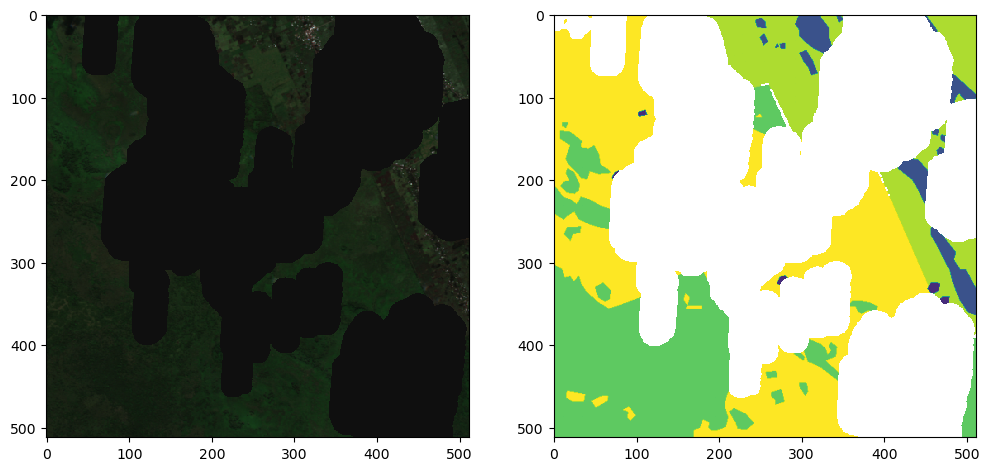

In [30]:
import matplotlib.pyplot as plt
from common.utilities.visualization import plot_bands


label_path = './data/labelbox/landcover/labels/S2A_35MQU_20220929_0_L2A_2936n1542959n126_3_3_90deg.tif'
source_path = './data/labelbox/landcover/source/S2A_35MQU_20220929_0_L2A_2936n1542959n126_3_3_90deg.tif'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

with rasterio.open(source_path) as src:
    source_data = src.read(masked=True)
    
with rasterio.open(label_path) as src:
    label_data = src.read(1, masked=True)
    
plot_bands(source_data, ax=ax1, bands=[2, 1, 0], transpose=True)
ax2.imshow(label_data, vmin=0, vmax=8)
plt.show()


## merge everything together
### right now there is only one source (Labelbox) so not super useful, but maybe in the future

In [4]:

merged_original_dir = "./data/mergedLandcoverTrainingData/original" # not using this right now...
merged_split_dir = "./data/mergedLandcoverTrainingData/split"


In [5]:
import glob
import multiprocessing
import os
import shutil


if os.path.exists(merged_original_dir):
    shutil.rmtree(merged_original_dir)

os.makedirs(f'{merged_original_dir}/source', exist_ok=True)
os.makedirs(f'{merged_original_dir}/labels', exist_ok=True)
os.makedirs(merged_split_dir, exist_ok=True)


def process_label_path(path):
    file_name = path.split('/')[-1]
    dst_path = f'{merged_original_dir}/labels/{file_name}'
    shutil.copy2(path, dst_path)

def process_source_path(path):
    file_name = path.split('/')[-1]
    dst_path = f'{merged_original_dir}/source/{file_name}'
    shutil.copy2(path, dst_path)

    
all_landcover_dirs = [labelbox_landcover_dir]    
for _dir in all_cloud_dirs:
    
    label_paths = glob.glob(f'{_dir}/labels/*.tif')
    print(f'{_dir}: {len(label_paths)} label paths')
    
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        pool.map(process_label_path, label_paths)

    # ensure that every label has source, otherwise throws exception
    source_paths = [p.replace('/labels/', '/source/') for p in label_paths]
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        pool.map(process_source_path, source_paths)

print('done')

NameError: name 'labelbox_landcover_dir' is not defined

## split data into train / test / val

In [ ]:
import os
import shutil
import splitfolders


if os.path.exists(merged_split_dir):
    shutil.rmtree(merged_split_dir)

splitfolders.ratio(merged_original_dir, output=merged_split_dir, seed=666, ratio=(0.80, 0.10, 0.10), group_prefix=None);

print('done')